# Freeze Bert Model Using CLS Token
### **Genre Label: 13**
### **Data: Under sampling (max 7000) || clean_df**
### **Bert Model: Uncase**
### **Multi-modal: 5 Numerical features**

In [1]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.63 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split


# Loading the Dataset and Encoding the Text

# Bert Model

In [5]:
from transformers import BertTokenizer, TFBertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
MAX_SEQUENCE_LENGTH = 250

In [7]:
cleaned_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/cleaned_df_2.pkl')

In [8]:
cleaned_df.head()

,release,danceability,energy,valence,lyrics,broad_genre,track_name,artist_name
2498,2009,0.635,0.746,0.548,"It's a sunny day, so I got nowhere to hide\nNo...",Pop,rain on me,cheryl
6415,1974,0.319,0.925,0.658,Goering's on the phone to Freiburg\nSay's Will...,Rock,me 262,blue öyster cult
43361,2009,0.357,0.708,0.470,Absorbing your words\nBattles raging within me...,Punk,nostalgia,the chameleons
21714,2008,0.809,0.913,0.648,"Yeah\nYeah\n\nLove always finds a way, every s...",Pop,one world,the cheetah girls
9623,2008,0.617,0.922,0.600,"Well, it's midnight, damn right\nWe're wound u...",Rock,burn it to the ground,nickelback


In [9]:
cleaned_df['broad_genre'].value_counts()

,count
broad_genre,
Rock,15998
Pop,15047
Rhythm & Blues,6864
Country,6282
Electronic,5406
Metal,5145
Punk,4914
Jazz,4352
Folk,4082


In [10]:
train_df, remaining_df = train_test_split(cleaned_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.50, random_state=42)

print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Test set shape:', test_df.shape)

Training set shape: (59256, 8)
Validation set shape: (7407, 8)
Test set shape: (7407, 8)


In [11]:
train_df['broad_genre'].value_counts()

,count
broad_genre,
Rock,12827
Pop,12022
Rhythm & Blues,5505
Country,5058
Electronic,4324
Metal,4092
Punk,3927
Jazz,3469
Folk,3279


In [12]:
# random undersample to fit the lowest class which is alternative
from sklearn.utils import resample

max_samples = 7000
undersampled_train_df = pd.DataFrame()

for genre in train_df['broad_genre'].unique():
    genre_df = train_df[train_df['broad_genre'] == genre]
    if len(genre_df) > max_samples:
        genre_df = resample(genre_df, replace=False, n_samples=max_samples, random_state=42)
    undersampled_train_df = pd.concat([undersampled_train_df, genre_df])

print('Training set genre distribution:')
print(undersampled_train_df['broad_genre'].value_counts())
train_df = undersampled_train_df.copy()

Training set genre distribution:
broad_genre
Pop               7000
Rock              7000
Rhythm & Blues    5505
Country           5058
Electronic        4324
Metal             4092
Punk              3927
Jazz              3469
Folk              3279
Hip Hop & Rap     2693
Reggae            2060
Name: count, dtype: int64


In [13]:
# getting the text and tables from train, validation and test
train_text = train_df['lyrics'].tolist()
val_text = val_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

train_label = train_df['broad_genre'].tolist()
val_label = val_df['broad_genre'].tolist()
test_label = test_df['broad_genre'].tolist()

In [14]:
train_df['lyric_length'] = train_df.lyrics.apply(lambda x: len(x.split()))
val_df['lyric_length'] = val_df.lyrics.apply(lambda x: len(x.split()))
test_df['lyric_length'] = test_df.lyrics.apply(lambda x: len(x.split()))

In [15]:
numerical_features = ['release', 'danceability', 'energy', 'valence', 'lyric_length']

# scaling numerical features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(train_df[numerical_features])
X_val_scale = scaler.transform(val_df[numerical_features])
X_test_scale = scaler.transform(test_df[numerical_features])

In [16]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
val_text = [preprocess_text(text) for text in val_text]
test_text = [preprocess_text(text) for text in test_text]


In [17]:
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
val_label = encode_label.transform(val_label)
test_label = encode_label.transform(test_label)

### Tokenize dataset with expanded genre label

In [18]:
word_len = [len(w.split()) for w in train_text]

sum(word_len) / len(word_len)

188.60544962505423

In [19]:
# training
train_tokenized = bert_tokenizer(train_text,
                                 max_length=MAX_SEQUENCE_LENGTH,
                                 truncation=True,
                                 padding='max_length',
                                 return_tensors='tf')
train_inputs = [train_tokenized.input_ids,
                train_tokenized.token_type_ids,
                train_tokenized.attention_mask,
                X_train_scale]
train_labels = np.array(train_label)

# validation
val_tokenized = bert_tokenizer(val_text,
                               max_length=MAX_SEQUENCE_LENGTH,
                               truncation=True,
                               padding='max_length',
                               return_tensors='tf')
val_inputs = [val_tokenized.input_ids,
              val_tokenized.token_type_ids,
              val_tokenized.attention_mask,
              X_val_scale]
val_labels = np.array(val_label)

# test
test_tokenized = bert_tokenizer(test_text,
                                max_length=MAX_SEQUENCE_LENGTH,
                                truncation=True,
                                padding='max_length',
                                return_tensors='tf')
test_inputs = [test_tokenized.input_ids,
               test_tokenized.token_type_ids,
               test_tokenized.attention_mask,
               X_test_scale]
test_labels = np.array(test_label)

In [20]:
print('Train input IDs shape:', train_inputs[0].shape)
print('Validation input IDs shape:', val_inputs[0].shape)
print('Test input IDs shape:', test_inputs[0].shape)
print('First tokenized train input:', train_inputs[0][0])
print('First tokenized validation input:', val_inputs[0][0])
print('First tokenized test input:', test_inputs[0][0])

Train input IDs shape: (48407, 250)
Validation input IDs shape: (7407, 250)
Test input IDs shape: (7407, 250)
First tokenized train input: tf.Tensor(
[  101  2514  4558  7200  2113  2272  8307  2963  3275  4558  2617 10436
  4452  3959  2895  6069 12985  2364  8432  5913  3342  2735  2157  3426
  2113  2444  9647  4826  7955 18987  3377  3342 12342  3362  2152  2514
  2907  2292  2066 12342 12342  2051  2088  2210  3553  2146  3201  2157
  2146  2514  2503  2113  4452  3959  2895  6069 12985  2364  8432  5913
  3342  2735  2157  3426  2113  2444  9647  4826  7955 18987  3377  3342
 12342  2425  2360  6211  2051  2689  2568 10587  2215  2342  2066  2342
  7200  4797  2903  4452  3959  2895  6069 12985  2364  8432  5913  3342
  2735  2157  3426  2113  2444  9647  4826  7955 18987  3377  3342 12342
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     

## Model function

In [ ]:
#@title Freeze Bert Classification Model using CLS

def freeze_bert_model_with_CLS(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          num_hidden = 1,
                          dropout=0.3,
                          learning_rate=2e-5,
                          last_layer_num=11,
                          num_classes=14,
                          num_non_text_features=5
                       ):
    # freezing all bert layers except the last transformer block
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    # Non-text features input
    non_text_features_input = tf.keras.layers.Input(shape=(num_non_text_features,), dtype=tf.float32, name='non_text_features')

    # Combine CLS token with non-text features
    combined_features = tf.keras.layers.Concatenate(name='combined_features')([cls_token, non_text_features_input])


    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(combined_features)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    for i in range(num_hidden - 1):
      hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name=f'hidden_layer_{i+1}')(hidden)
      hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, non_text_features_input], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    return classification_model

## Models

In [21]:
num_classes = 13
checkpoint_dir = '/content/drive/MyDrive/w266/266 Final Project/model_checkpoints/'
bert_last_layer_num = 11

### 1 Hidden Layer

In [ ]:
bert_model_8 = freeze_bert_model_with_CLS(
    bert_model,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=200,
    dropout=0.3,
    learning_rate=2e-5,
    last_layer_num=bert_last_layer_num,
    num_classes = num_classes,
    num_non_text_features=len(numerical_features)
)

bert_model_8.summary()

In [22]:
#calculate sample weights
sample_weight = np.ones(shape=(len(train_labels),))
for label in range(np.max(train_labels) + 1):
    class_weight = 1 - np.sum(train_labels == label) / len(train_labels)
    sample_weight[train_labels == label] = class_weight

# setting up check points
checkpoint_prefix = checkpoint_dir + 'bert_weights_%s'
checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

In [ ]:
bert_model_8_history = bert_model_8.fit(
    train_inputs,
    train_labels,
    sample_weight=sample_weight,
    validation_data=(val_inputs, val_labels),
    epochs=4,
    batch_size=8,
    callbacks=[model_checkpoint_callback]
)


Epoch 1/4


6051/6051 [==============================] - 1301s 212ms/step - loss: 1.6155 - accuracy: 0.3433 - val_loss: 1.5781 - val_accuracy: 0.4064
Epoch 2/4
6051/6051 [==============================] - 1277s 211ms/step - loss: 1.4368 - accuracy: 0.4126 - val_loss: 1.5258 - val_accuracy: 0.4268
Epoch 3/4
6051/6051 [==============================] - 1278s 211ms/step - loss: 1.3615 - accuracy: 0.4455 - val_loss: 1.4857 - val_accuracy: 0.4494
Epoch 4/4
6051/6051 [==============================] - 1264s 209ms/step - loss: 1.3028 - accuracy: 0.4674 - val_loss: 1.4476 - val_accuracy: 0.4656


In [ ]:
val_predictions = bert_model_8.predict(val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(val_labels, val_predictions, target_names=encode_label.classes_))


232/232 [==============================] - 130s 550ms/step
                precision    recall  f1-score   support

       Country       0.46      0.61      0.53       600
    Electronic       0.27      0.42      0.33       509
          Folk       0.40      0.55      0.46       402
 Hip Hop & Rap       0.81      0.75      0.78       343
          Jazz       0.37      0.45      0.41       462
         Metal       0.61      0.71      0.66       526
           Pop       0.53      0.40      0.46      1489
          Punk       0.37      0.44      0.40       463
        Reggae       0.54      0.46      0.49       290
Rhythm & Blues       0.35      0.38      0.36       693
          Rock       0.56      0.37      0.45      1630

      accuracy                           0.47      7407
     macro avg       0.48      0.50      0.48      7407
  weighted avg       0.49      0.47      0.47      7407



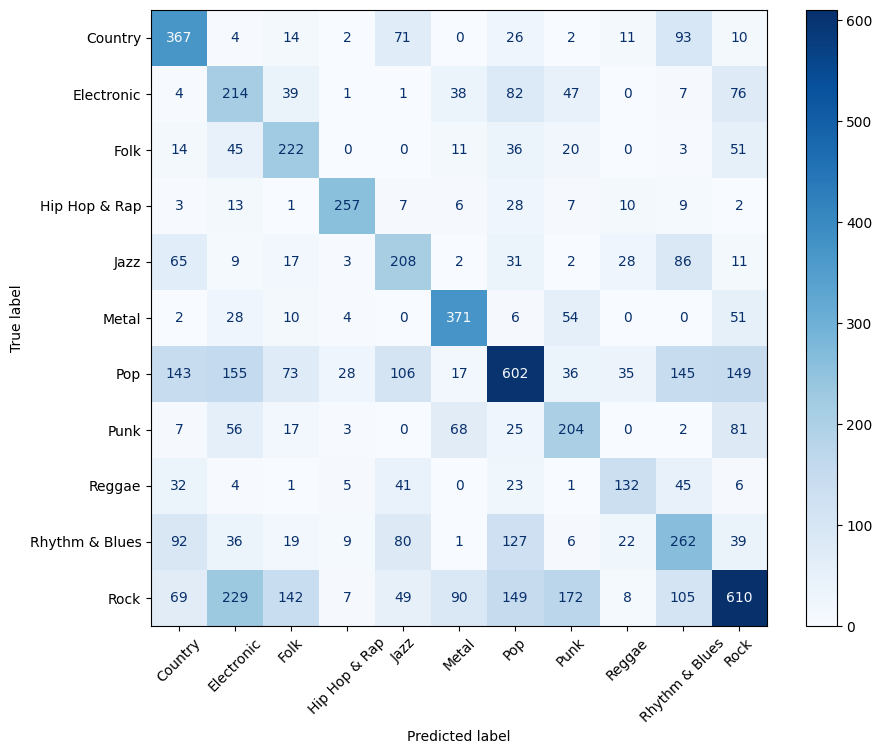

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(val_labels, val_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encode_label.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.xticks(rotation=45)
plt.show()

## Hypertune Bert Model

In [23]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [24]:
import optuna
from transformers import BertConfig, TFBertModel

In [25]:
from transformers import BertConfig, TFBertModel
# function to create custom configuration for bert model to have attention head, intermediate/feed forward layer, dropout probability and attention drop out probability

def get_custom_bert_config(num_attention_heads=4):
    return BertConfig(
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=num_attention_heads,
        intermediate_size=3072,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
    )

In [26]:

def freeze_bert_model_update(bert_base_model,
                             max_sequence_length=250,
                             hidden_size=150,
                             dropout=0.3,
                             learning_rate=2e-5,
                             last_layer_num=11,
                             num_classes=13,
                             num_non_text_features = 5):
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    # Non-text features input
    non_text_features_input = tf.keras.layers.Input(shape=(num_non_text_features,), dtype=tf.float32, name='non_text_features')

    # Combine CLS token with non-text features
    combined_features = tf.keras.layers.Concatenate(name='combined_features')([cls_token, non_text_features_input])

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(combined_features)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, non_text_features_input], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    return classification_model


In [27]:
def objective(trial):
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [8,12,16])
    hidden_size = trial.suggest_categorical('hidden_size', [400, 600, 800]) # updated hidden size
    dropout = 0.1 # keeping drop out at 0.1
    batch_size = trial.suggest_categorical('batch_size', [16, 32]) # adding batch size to the experiment
    learning_rate = trial.suggest_categorical('learning_rate', [3e-5, 4e-5, 5e-5])
    last_layer_num = 11 # i think we should keep the last layer as 11 since were freezing all the layers except the top so we can fine tune it

    custom_config = get_custom_bert_config(num_attention_heads=num_attention_heads)
    bert_base_model = TFBertModel.from_pretrained('bert-base-uncased', config=custom_config)
    model = freeze_bert_model_update(bert_base_model,
                                     hidden_size=hidden_size,
                                     dropout=dropout,
                                     learning_rate=learning_rate,
                                     last_layer_num=last_layer_num,
                                     num_classes=14)

    bert_model_4_history_update = model.fit(
    train_inputs,
    train_labels,
    sample_weight=sample_weight,
    validation_data=(val_inputs, val_labels),
    epochs=3,
    batch_size= batch_size,
    callbacks=[model_checkpoint_callback]
)

    val_loss = bert_model_4_history_update.history['val_loss'][-1]
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-08-02 23:38:45,992] A new study created in memory with name: no-name-1217a43e-4a4c-4e3a-83c6-5e18bdb0d18f
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3


1513/1513 [==============================] - 1148s 752ms/step - loss: 1.4593 - accuracy: 0.3962 - val_loss: 1.4744 - val_accuracy: 0.4529
Epoch 2/3
1513/1513 [==============================] - 1142s 755ms/step - loss: 1.2876 - accuracy: 0.4698 - val_loss: 1.4381 - val_accuracy: 0.4592
Epoch 3/3
1513/1513 [==============================] - 1151s 760ms/step - loss: 1.2163 - accuracy: 0.4970 - val_loss: 1.4028 - val_accuracy: 0.4767


[I 2024-08-03 00:36:13,184] Trial 0 finished with value: 1.4028472900390625 and parameters: {'num_attention_heads': 12, 'hidden_size': 400, 'batch_size': 32, 'learning_rate': 5e-05}. Best is trial 0 with value: 1.4028472900390625.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you ca

Epoch 1/3


1513/1513 [==============================] - 1156s 758ms/step - loss: 1.4752 - accuracy: 0.3887 - val_loss: 1.5125 - val_accuracy: 0.4358
Epoch 2/3
1513/1513 [==============================] - 1152s 761ms/step - loss: 1.3048 - accuracy: 0.4619 - val_loss: 1.4317 - val_accuracy: 0.4665
Epoch 3/3
1513/1513 [==============================] - 1148s 759ms/step - loss: 1.2337 - accuracy: 0.4925 - val_loss: 1.4005 - val_accuracy: 0.4854


[I 2024-08-03 01:33:51,534] Trial 1 finished with value: 1.4004663228988647 and parameters: {'num_attention_heads': 12, 'hidden_size': 400, 'batch_size': 32, 'learning_rate': 4e-05}. Best is trial 1 with value: 1.4004663228988647.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you ca

Epoch 1/3


1513/1513 [==============================] - 1116s 732ms/step - loss: 1.4495 - accuracy: 0.3938 - val_loss: 1.4813 - val_accuracy: 0.4547
Epoch 2/3
1513/1513 [==============================] - 1103s 729ms/step - loss: 1.2833 - accuracy: 0.4684 - val_loss: 1.4193 - val_accuracy: 0.4702
Epoch 3/3
1513/1513 [==============================] - 1099s 726ms/step - loss: 1.2241 - accuracy: 0.4927 - val_loss: 1.4182 - val_accuracy: 0.4683


[I 2024-08-03 02:29:12,736] Trial 2 finished with value: 1.4181686639785767 and parameters: {'num_attention_heads': 8, 'hidden_size': 800, 'batch_size': 32, 'learning_rate': 5e-05}. Best is trial 1 with value: 1.4004663228988647.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can

Epoch 1/3


1513/1513 [==============================] - 1156s 759ms/step - loss: 1.4691 - accuracy: 0.3897 - val_loss: 1.5028 - val_accuracy: 0.4426
Epoch 2/3
1513/1513 [==============================] - 1143s 756ms/step - loss: 1.2981 - accuracy: 0.4670 - val_loss: 1.4250 - val_accuracy: 0.4763
Epoch 3/3
1513/1513 [==============================] - 1146s 758ms/step - loss: 1.2344 - accuracy: 0.4931 - val_loss: 1.3960 - val_accuracy: 0.4889


[I 2024-08-03 03:26:41,969] Trial 3 finished with value: 1.3959661722183228 and parameters: {'num_attention_heads': 12, 'hidden_size': 800, 'batch_size': 32, 'learning_rate': 3e-05}. Best is trial 3 with value: 1.3959661722183228.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you ca

Epoch 1/3


1513/1513 [==============================] - 1212s 795ms/step - loss: 1.4591 - accuracy: 0.3925 - val_loss: 1.5039 - val_accuracy: 0.4258
Epoch 2/3
1513/1513 [==============================] - 1199s 793ms/step - loss: 1.2890 - accuracy: 0.4677 - val_loss: 1.4130 - val_accuracy: 0.4712
Epoch 3/3
1513/1513 [==============================] - 1205s 796ms/step - loss: 1.2230 - accuracy: 0.4929 - val_loss: 1.4316 - val_accuracy: 0.4605


[I 2024-08-03 04:27:02,031] Trial 4 finished with value: 1.4316486120224 and parameters: {'num_attention_heads': 16, 'hidden_size': 800, 'batch_size': 32, 'learning_rate': 5e-05}. Best is trial 3 with value: 1.3959661722183228.


Best trial:
  Value: 1.3959661722183228
  Params: 
    num_attention_heads: 12
    hidden_size: 800
    batch_size: 32
    learning_rate: 3e-05
